In [228]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.stats import ttest_ind, pearsonr
from sklearn.metrics import confusion_matrix as cm, roc_curve, roc_auc_score
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox, AnchoredText)

## Display element 1 - CAID
Drafted, refinements needed

In [229]:
def draw_consensus_schema(ax):
    ax.set(title="CAID Negative definition")
    colm = 'w'
    cold = 'r'
    cols = 'b'
    colu = 'grey' 
    h = .5

    regs = [[[70, 20, 10], [70, 15, 15]],                   # disprot
            [[15, 35, 10, 5, 35], [7, 15, 43, 35]],         # pdb
            [[22, 28, 10, 5, 5, 20, 10]],                   # consensus 
            [[70, 20, 10], [22, 28, 10, 5, 5, 20, 10]]]     # ground truth

    groups = np.hstack([[i]*len(g) for i,g in enumerate(regs)])
    groupn = [len(r) for r in regs]
    regs = [r for g in regs for r in g]
    lefts = [np.cumsum([0] + r[:-1]) for r in regs]
    ys = [-1*np.full((len(r), ), i) for i, r in enumerate(regs)]
    ys = [y-i for i, y in zip(groups, ys)]

    colors = [[colu, cold, colu], [colu, cold, colu],
              [colu, cols, cold, cols, colu], [colu, cold, cols, colu],
              [colu, cols, colu, cols, colu, cold, colu],
              [cols, cold, cols],
              [colm, cols, colm, cols, colm, cold, colm]]

    rects = ax.barh(np.hstack(ys), 
            np.hstack(regs), 
            height=h,
            left=np.hstack(lefts), 
            color=np.hstack(colors))

    for x in np.cumsum(regs[-1][:-1]):
        ax.axvline(x, ymin=0.05, ymax=.95, linestyle="--")

    ax.set_yticks(np.unique(np.hstack(ys))[::-1]);
    ax.set_yticklabels(["DisProt 1", "DisProt 2", "PDB 1", "PDB 2", "Consensus", "Simple", "PDB"]);
    groupl = ["DisProt", "PDB", "", "Ground truth"]

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
 
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    j=0
    for i, l in zip(np.cumsum(groupn), groupl):
        y = np.unique(np.hstack(ys[j:i])).mean()
        ax.text(103, y, l)
        j=i
    
    ax.legend([Patch(facecolor=colu), Patch(facecolor=cold), Patch(facecolor=cols)], ['Undefined', "Disorder", "Structure"], bbox_to_anchor=(0.,-0.1, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)

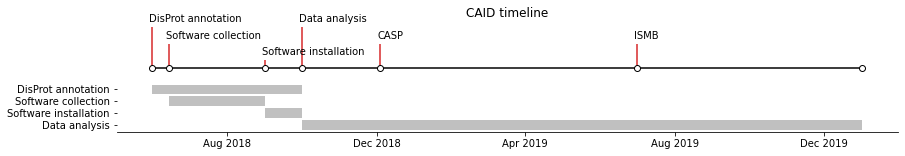

In [230]:
def draw_caid_timeline(ax, names=None, dates=None):
    ax, ax2 = ax
    names = ["DisProt annotation", "Software collection", "Software installation", "CASP", "Data analysis", "ISMB", ""]

    dates = ["2018-06-01", "2018-06-15", "2018-09-01", "2018-12-04", "2018-10-01", "2019-07-01", "2020-01-01"]
    
    periods = [("DisProt annotation", "2018-06-01", "2018-10-01"),
               ("Software collection", "2018-06-15", "2018-09-01"),
               ("Software installation", "2018-09-01", "2018-10-01"),
               ("Data analysis", "2018-10-01", "2020-01-01")]
    
#     colors = ["b", "darkorange", "g", "r"]
    # Convert date strings (e.g. 2014-10-18) to datetime
    dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
    for i, (event, startdate, enddate) in enumerate(periods, 1):
        startdate, enddate = datetime.strptime(startdate,"%Y-%m-%d"), datetime.strptime(enddate, "%Y-%m-%d")
        ax2.barh(i, [enddate - startdate], left=[startdate], color="silver")
#         ax2.text(enddate, i, event, va="center", ha="left")
    ax2.set_yticks(range(1, 5))
    ax2.set_yticklabels(list(zip(*periods))[0])
#     print(list(zip(*periods))[0])
    ax2.invert_yaxis()
    

    # Choose some nice levels
    levels = np.tile([5, 3, 1, 3, 5, 3, 0],
                     int(np.ceil(len(dates)/6)))[:len(dates)]

    # Create figure and plot a stem plot with the date
    ax.set(title="CAID timeline")

    markerline, stemline, baseline = ax.stem(dates, levels,
                                             linefmt="C3-", basefmt="k-",
                                             use_line_collection=True)

    plt.setp(markerline, mec="k", mfc="w", zorder=3)
#     maxtimedelta = dates[-1] -dates[0] 
#     for i, (event, startdate, enddate) in enumerate(periods, 1):
        
#         startdate, enddate = datetime.strptime(startdate,"%Y-%m-%d"), datetime.strptime(enddate, "%Y-%m-%d")
#         ax3.stem([startdate, enddate], [levels[i]]*2, linefmt="C3-", basefmt="k-", use_line_collection=True)
#         ax3.axhline(levels[i], xmin=(enddate - startdate).days / maxtimedelta.days)

    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))

    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, r, va in zip(dates, levels, names, vert):
        ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                    textcoords="offset points", va=va, ha="left")

    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="left")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
    for spine in ["left", "top", "right", "bottom"]:
        ax.spines[spine].set_visible(False)
        
#     ax2.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax2.spines[spine].set_visible(False)

    ax.margins(y=0.1)
    plt.minorticks_off()


fig, ax = plt.subplots(2, 1, figsize=(14, 2), sharex=True)
draw_caid_timeline(ax)

In [231]:
def draw_dataset_stats(stats, ax1, ax2, ax3, ax4):
    stats = stats.drop(["PDB missing", "DisProt linker"], level=1)
    colors = ["r", "b"]
    stats.xs("DisProt 8").Simple.Reg.plot.barh(ax=ax1, legend=None, color=colors)
    ax1.set_title("Regions (Simple)")

    stats.xs("DisProt 8").PDB.Reg.plot.barh(ax=ax2, color=colors)
    ax2.set_title("Regions (PDB)")

    stats.xs("DisProt 8").Simple.Res.plot.barh(ax=ax3, legend=None, color=colors)
    ax3.set_title("Residues (Simple)")

    stats.xs("DisProt 8").PDB.Res.plot.barh(ax=ax4, color=colors)
    ax4.set_title("Residues (PDB)")
    plt.tight_layout()
    
#     ax4.legend(bbox_to_anchor=(-1.6,-0.2, 2.6, .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
    

In [232]:
def draw_caid_process(ax):
    ax.set_title("CAID process")
    # article
    images = ["/home/marnec/Projects/CAID/caid/caid/users.png",  
              "/home/marnec/Projects/CAID/caid/caid/article.png", 
              "/home/marnec/Projects/CAID/caid/caid/evaluation.png",
              "/home/marnec/Projects/CAID/caid/caid/server.png"]
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

    
#     prev_ab = None
#     prev_bb = None
#     for coords, img in zip([(.2, .2), (.8, .2), (.8, .8), (.2, .8)], images):
#         arr_img = plt.imread(img, format='png')
#         imagebox = OffsetImage(arr_img, zoom=0.1)
#         imagebox.image.axes = ax

#         r = ax.figure.canvas.get_renderer()
#         transf = ax.transData.inverted()
        
#         ab = AnnotationBbox(imagebox, (prev_ab.xybox[0]+prev_bb.x0, prev_ab.xybox[1]) if prev_ab else (.2, .7),
#                 frameon=False,
#                 xybox=coords,
#                 xycoords='data',
#                 boxcoords="axes fraction",
#                 pad=0.,
#                 arrowprops=dict(arrowstyle="->"))
        
#         bb = ab.get_window_extent(renderer = r)
#         bb_datacoords = bb.transformed(transf)
        
#         ax.add_artist(ab)
#         prev_ab = ab
#         prev_bb = bb_datacoords
    
    arr_img = plt.imread("/home/marnec/Projects/CAID/caid/caid/data/img/article.png", format='png')
    imagebox = OffsetImage(arr_img, zoom=0.05)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (0.25, 0.6),
                        frameon=False,
                        xybox=(0.25, 0.3),
                        xycoords='data',
                        boxcoords="axes fraction",
                        pad=0.,
                        arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)
    
    
    arr_img = plt.imread("/home/marnec/Projects/CAID/caid/caid/data/img/users.png", format='png')
    imagebox = OffsetImage(arr_img, zoom=0.05)
    imagebox.image.axes = ax
    
    ab = AnnotationBbox(imagebox, (0.65,  0.7),
                        frameon=False,
                        xybox=(0.25, 0.7),
                        xycoords='data',
                        boxcoords="axes fraction",
                        pad=0.,
                        arrowprops=dict(arrowstyle="->"))
    
    ax.add_artist(ab)
    
    arr_img = plt.imread("/home/marnec/Projects/CAID/caid/caid/data/img/server.png", format='png')
    imagebox = OffsetImage(arr_img, zoom=0.035)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, (0.75, 0.4),
                        frameon=False,
                        xybox=(0.75, 0.7),
                        xycoords='data',
                        boxcoords="axes fraction",
                        pad=0.,
                        arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)
    
    
    arr_img = plt.imread("/home/marnec/Projects/CAID/caid/caid/data/img/evaluation.png", format='png')
    imagebox = OffsetImage(arr_img, zoom=0.05)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, (0.35, 0.3),
                        frameon=False,
                        xybox=(0.75, 0.3),
                        xycoords='data',
                        boxcoords="axes fraction",
                        pad=0.,
                        arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)

    at = AnchoredText("Report",
                      frameon=False,
                      loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    at = AnchoredText("Annotation",
                      frameon=False,
                      loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    at = AnchoredText("Prediction",
                      frameon=False,
                      loc='upper right')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    at = AnchoredText("Evaluation",
                      frameon=False,
                      loc='lower right')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
# fig, ax = plt.subplots()
# draw_caid_process(ax)

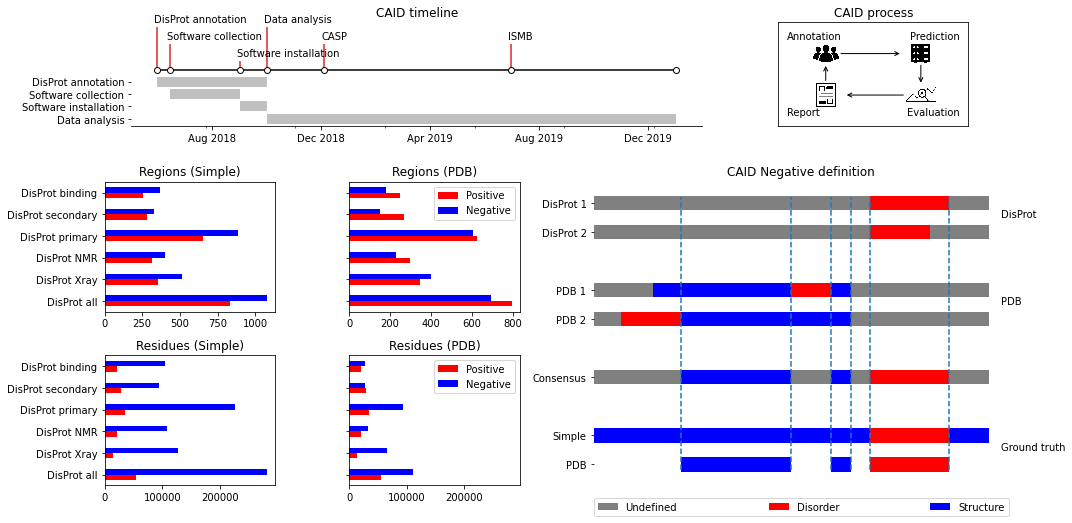

In [233]:
import warnings
warnings.filterwarnings("ignore")

heights = [1, 1]
widths = [1, 3, 2]



fig = plt.figure(figsize=(15, 8))

gs = fig.add_gridspec(2, 2, bottom=0.7, hspace=0, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[:, 1])

gs = fig.add_gridspec(2, 4, top=0.7, height_ratios=heights)
# ax1 = fig.add_subplot(gs[0, :])
# ax2 = fig.add_subplot(gs[1, :], sharex=ax1)
# ax3 = fig.add_subplot(gs[0, :])
ax4 = fig.add_subplot(gs[0, 0]) 
ax5 = fig.add_subplot(gs[0, 1], sharey=ax4)
ax6 = fig.add_subplot(gs[1, 0])
ax7 = fig.add_subplot(gs[1, 1], sharex=ax6, sharey=ax6)
ax8 = fig.add_subplot(gs[0:, 2:])

stats = pd.read_csv("/home/marnec/Projects/CAID/caid/data/referenceStats.csv", index_col=[0,1], header=[0,1,2])
draw_caid_timeline(ax=[ax1, ax2])
draw_caid_process(ax=ax3)
draw_dataset_stats(stats, ax4, ax5, ax6, ax7)
draw_consensus_schema(ax=ax8)

gs.tight_layout(fig, rect=(0, 0, 1, 0.65))
plt.savefig("fig1.png", dpi=300)

In [234]:
metrics_simple_target_preds = pd.read_csv("../results/new-disprot-all_simple.analysis.all.target.default.metrics.csv", index_col=[0,1])
metrics_simple_target_npdbr = pd.read_csv("../baseline/new-disprot-all_simple.naive-new-pdb-r_simple.all.target.default.metrics.csv", index_col=[0,1])
metrics_simple_target_ngen3 = pd.read_csv("../baseline/new-disprot-all_simple.naive-new-gene3d-r_simple.all.target.default.metrics.csv", index_col=[0,1])
metrics_simple_target_nfixf = pd.read_csv("../baseline/new-disprot-all_simple.fixedposfrc.all.target.default.metrics.csv", index_col=[0,1])

In [235]:
metrics_pdb_target_preds = pd.read_csv("../results/new-disprot-all_pdb.analysis.all.target.default.metrics.csv", index_col=[0,1])
metrics_pdb_target_npdbr = pd.read_csv("../baseline/new-disprot-all_pdb.naive-new-pdb-r_simple.all.target.default.metrics.csv", index_col=[0,1])
metrics_pdb_target_ngen3 = pd.read_csv("../baseline/new-disprot-all_pdb.naive-new-gene3d-r_simple.all.target.default.metrics.csv", index_col=[0,1])
metrics_pdb_target_nfixf = pd.read_csv("../baseline/new-disprot-all_pdb.fixedposfrc.all.target.default.metrics.csv", index_col=[0,1])

In [236]:
mcc_simple_targetavg_preds = metrics_simple_target_preds.mcc.groupby(level=0).describe()[["mean", "std"]].sort_values("mean",ascending=False)
mcc_simple_targetavg_base = pd.concat(
    [metrics_simple_target_ngen3.mcc.describe()[["mean", "std"]].to_frame().T.rename({"mcc": "gene3d"}),
     metrics_simple_target_npdbr.mcc.describe()[["mean", "std"]].to_frame().T.rename({"mcc": "pdb"}),
     metrics_simple_target_nfixf.mcc.describe()[["mean", "std"]].to_frame().T.rename({"mcc": "fixid"})], sort=False).sort_values("mean", ascending=False)

mcc_simple_plot_data = mcc_simple_targetavg_preds.head(10).append(mcc_simple_targetavg_base)

In [237]:
mcc_pdb_targetavg_preds = metrics_pdb_target_preds.mcc.groupby(level=0).describe()[["mean", "std"]].sort_values("mean",ascending=False)
mcc_pdb_targetavg_base = pd.concat(
    [metrics_pdb_target_ngen3.mcc.describe()[["mean", "std"]].to_frame().T.rename({"mcc": "gene3d"}),
     metrics_pdb_target_npdbr.mcc.describe()[["mean", "std"]].to_frame().T.rename({"mcc": "pdb"}),
     metrics_pdb_target_nfixf.mcc.describe()[["mean", "std"]].to_frame().T.rename({"mcc": "fixid"})], sort=False).sort_values("mean", ascending=False)

mcc_pdb_plot_data = mcc_pdb_targetavg_preds.head(10).append(mcc_pdb_targetavg_base)

## Display element 2 - MCC
MCC of the first 10 predictors and 3 baselines. MCC is calculated for each target and its mean and standard deviations are plotted as a bar plot with error whiskers.

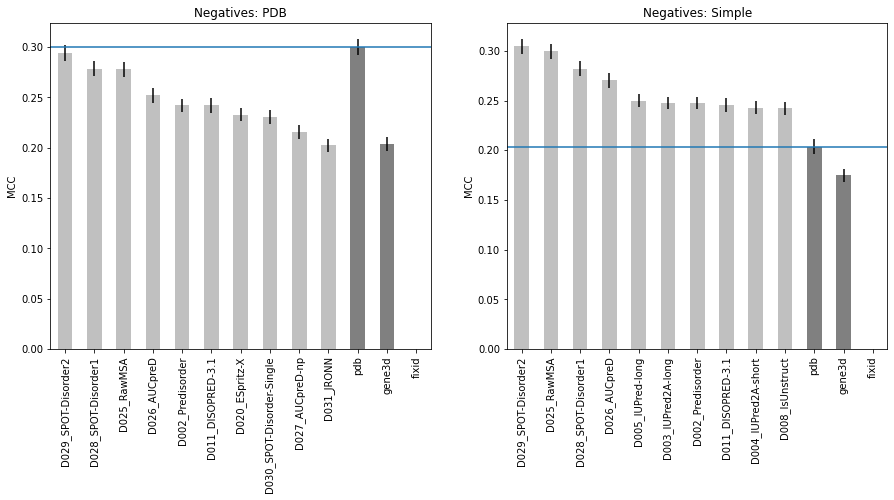

In [250]:
fig, axes = plt.subplots(1,2, figsize=(15, 6))

ax = mcc_pdb_plot_data["mean"].plot.bar(ax=axes[0], color=(["silver"]*10) + (["grey"]*3), yerr=mcc_pdb_plot_data["std"] / 600**0.5 /2)
_ = ax.axhline(mcc_pdb_targetavg_base["mean"].max())
_ = ax.set_ylabel("MCC")
ax.title.set_text('Negatives: PDB')


ax = mcc_simple_plot_data["mean"].plot.bar(ax=axes[1], color=(["silver"]*10) + (["grey"]*3), yerr=mcc_simple_plot_data["std"] / 600**0.5 /2)
_ = ax.axhline(mcc_simple_targetavg_base["mean"].max())
_ = ax.set_ylabel("MCC")
ax.title.set_text('Negatives: Simple')
plt.savefig("fig2.png", dpi=300, bbox_inches="tight")

In [239]:
roc_simple_preds = pd.read_csv("../results/new-disprot-all_simple.analysis.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_simple_npdbr = pd.read_csv("../baseline/new-disprot-all_simple.naive-new-pdb-r_simple.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_simple_ngen3 = pd.read_csv("../baseline/new-disprot-all_simple.naive-new-gene3d-r_simple.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_simple_ncons = pd.read_csv("../baseline/new-disprot-all_simple.cons.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])

In [240]:
roc_pdb_preds = pd.read_csv("../results/new-disprot-all_pdb.analysis.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_pdb_npdbr = pd.read_csv("../baseline/new-disprot-all_pdb.naive-new-pdb-r_simple.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_pdb_ngen3 = pd.read_csv("../baseline/new-disprot-all_pdb.naive-new-gene3d-r_simple.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_pdb_ncons = pd.read_csv("../baseline/new-disprot-all_pdb.cons.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])

In [241]:
# create auc ranking of all predictor + baselines
auc_simple = sorted(roc_simple_preds.join(roc_simple_npdbr).join(roc_simple_ngen3).join(roc_simple_ncons).columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
# select first 10 predictors 
roc_simple = roc_simple_preds.reindex(list(zip(*auc_simple))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
roc_simple = roc_simple.append(roc_simple_npdbr.T) if roc_simple_npdbr.index.get_level_values(0)[0] not in roc_simple.index.get_level_values('predictor').unique() else roc_simple
roc_simple = roc_simple.append(roc_simple_ngen3.T) if roc_simple_ngen3.index.get_level_values(0)[0] not in roc_simple.index.get_level_values('predictor').unique() else roc_simple
roc_simple = roc_simple.append(roc_simple_ncons.T) if roc_simple_ncons.index.get_level_values(0)[0] not in roc_simple.index.get_level_values('predictor').unique() else roc_simple
# recreate auc ranking with first 10 predictors and baselines

In [242]:
# create auc ranking of all predictor + baselines
auc_pdb = sorted(roc_pdb_preds.join(roc_pdb_npdbr).join(roc_pdb_ngen3).join(roc_pdb_ncons).columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
# select first 10 predictors 
roc_pdb = roc_pdb_preds.reindex(list(zip(*auc_pdb))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
roc_pdb = roc_pdb.append(roc_pdb_npdbr.T) if roc_pdb_npdbr.index.get_level_values(0)[0] not in roc_pdb.index.get_level_values('predictor').unique() else roc_pdb
roc_pdb = roc_pdb.append(roc_pdb_ngen3.T) if roc_pdb_ngen3.index.get_level_values(0)[0] not in roc_pdb.index.get_level_values('predictor').unique() else roc_pdb
roc_pdb = roc_pdb.append(roc_pdb_ncons.T) if roc_pdb_ncons.index.get_level_values(0)[0] not in roc_pdb.index.get_level_values('predictor').unique() else roc_pdb
# recreate auc ranking with first 10 predictors and baselines

## Display element 3 - ROC curve
ROC curve of the best 10 ranking methods (ranking is based on ROC AUC) and baselines. X axis is 1-specificity; Y axis is sensitivity.

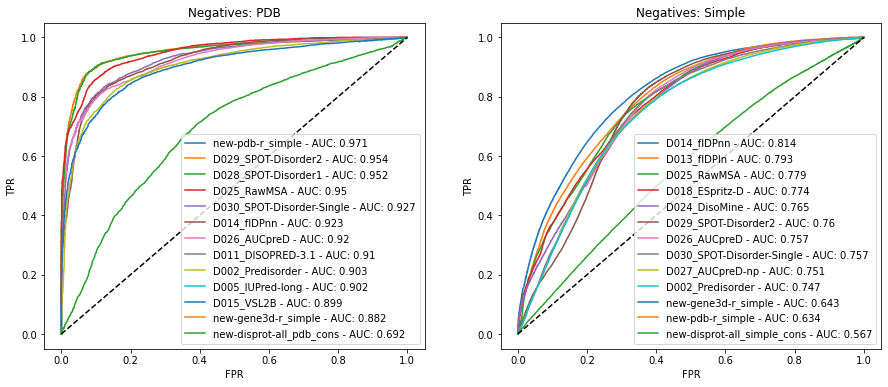

In [251]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

auc_pdb = sorted(roc_pdb.index.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
lines = axes[0].plot(*roc_pdb.reindex(list(zip(*auc_pdb))[0], level=0).values)
axes[0].plot([0, 1], [0, 1], color='k', linestyle='--')

axes[0].legend(lines, ["{} - AUC: {}".format(*t) for t in auc_pdb]);
axes[0].set_ylabel("TPR")
axes[0].set_xlabel("FPR")
axes[0].title.set_text('Negatives: PDB')

auc_simple = sorted(roc_simple.index.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
lines = axes[1].plot(*roc_simple.reindex(list(zip(*auc_simple))[0], level=0).values)
axes[1].plot([0, 1], [0, 1], color='k', linestyle='--')

axes[1].legend(lines, ["{} - AUC: {}".format(*t) for t in auc_simple]);
axes[1].set_ylabel("TPR")
axes[1].set_xlabel("FPR")
axes[1].title.set_text('Negatives: Simple')
plt.savefig("fig3.png", dpi=300, bbox_inches="tight")

## Display element 4 - Fully ID table
Performance of predictors (shown as confusion matrix) on their ability to discriminate fully disordered proteins (>95% id content) from non-fully disordered proteins.

In [252]:
predictions = pd.read_csv("/home/marnec/Projects/CAID/caid/results/new-disprot-all_simple.analysis.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_cons = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.cons.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_pdbr = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.naive-new-pdb-r_simple.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_gene3dr = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.naive-new-gene3d-r_simple.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
predictions = pd.DataFrame({**predictions.to_dict(), **baseline_cons.to_dict(), **baseline_pdbr.to_dict(), **baseline_gene3dr.to_dict()}).dropna()

In [253]:
idcontent_ref = predictions[("ref", "states")].groupby(level=0).mean()
idcontent_pred = predictions.groupby(level=0).mean()

In [254]:
fullid = (idcontent_pred.xs("states", axis=1, level=1).round(3) > 0.95).astype(int)
fullid_r = fullid["ref"].astype(int)
fullid_p = fullid.astype(int).drop("ref", axis=1)
fullid_cm = fullid.apply(lambda s: cm(fullid_r.values, s.values, labels=[0, 1]).ravel())
fullid_cm.index = ["tn", "fp", "fn", "tp"]
fullid_cm.index = pd.MultiIndex.from_product([['Negatives: Simple'], fullid_cm.index])
# fullid_cm.T.sort_values(("Negatives: Simple", "fp")).drop("ref")
fullid_cm = fullid_cm.T.sort_values(("Negatives: Simple", "fp")).drop("ref")
fullid_cm.to_csv("fig4.csv")

## Display element 5 - Binding
MCC and ROC curve for binding

In [255]:
metrics_simple_target_preds_binding = pd.read_csv("../results/new-disprot-binding_simple.analysis.all.target.default.metrics.csv", index_col=[0, 1])
metrics_simple_target_npdbr_binding = pd.read_csv("../baseline/new-disprot-binding_simple.naive-new-disprot-binding_pdb.all.target.default.metrics.csv", index_col=[0, 1])
metrics_simple_target_ngen3_binding = pd.read_csv("../baseline/new-disprot-binding_simple.naive-new-disprot-binding_gene3d.all.target.default.metrics.csv", index_col=[0, 1])
metrics_simple_target_nfixf_binding = pd.read_csv("../baseline/new-disprot-binding_simple.fixedposfrc.all.target.default.metrics.csv", index_col=[0, 1])

In [256]:
mcc_simple_targetavg_preds_binding = metrics_simple_target_preds_binding.mcc.groupby(level=0).describe()[["mean", "std"]].sort_values("mean",ascending=False)

mcc_simple_targetavg_base_binding = pd.concat(
    [metrics_simple_target_ngen3_binding["mcc"].describe()[["mean", "std"]].to_frame().T.rename({"mcc": "gene3d"}),
     metrics_simple_target_npdbr_binding["mcc"].describe()[["mean", "std"]].to_frame().T.rename({"mcc": "pdb"}),
     metrics_simple_target_nfixf_binding["mcc"].describe()[["mean", "std"]].to_frame().T.rename({"mcc": "fixid"})], sort=False).sort_values("mean", ascending=False)

mcc_simple_plot_data_binding = mcc_simple_targetavg_preds_binding.head(10).append(mcc_simple_targetavg_base_binding)


In [257]:
roc_simple_preds_binding = pd.read_csv("../results/new-disprot-binding_simple.analysis.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_simple_npdbr_binding = pd.read_csv("../baseline/new-disprot-binding_simple.naive-new-disprot-binding_pdb.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_simple_ngen3_binding = pd.read_csv("../baseline/new-disprot-binding_simple.naive-new-disprot-binding_gene3d.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
# roc_simple_ncons = pd.read_csv("../baseline/new-disprot-all_simple.cons.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])

In [258]:
# create auc ranking of all predictor + baselines
auc_simple = sorted(roc_simple_preds_binding.join(roc_simple_npdbr_binding).join(roc_simple_ngen3_binding).columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
# select first 10 predictors 
roc_simple = roc_simple_preds_binding.reindex(list(zip(*auc_simple))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
roc_simple = roc_simple.append(roc_simple_npdbr_binding.T) if roc_simple_npdbr_binding.index.get_level_values(0)[0] not in roc_simple.index.get_level_values('predictor').unique() else roc_simple
roc_simple = roc_simple.append(roc_simple_ngen3_binding.T) if roc_simple_ngen3_binding.index.get_level_values(0)[0] not in roc_simple.index.get_level_values('predictor').unique() else roc_simple
# roc_simple = roc_simple.append(roc_simple_ncons.T) if roc_simple_ncons.index.get_level_values(0)[0] not in roc_simple.index.get_level_values('predictor').unique() else roc_simple
# recreate auc ranking with first 10 predictors and baselines

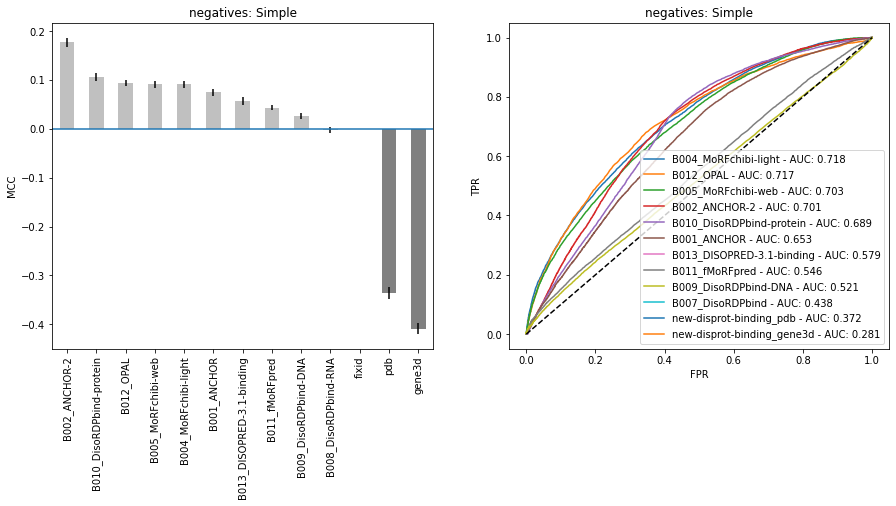

In [259]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = mcc_simple_plot_data_binding["mean"].plot.bar(ax=axes[0], color=(["silver"]*10) + (["grey"]*3), yerr=mcc_simple_plot_data_binding["std"] / (len(metrics_simple_target_preds_binding.index.get_level_values(1).unique()) **0.5) / 2)
_ = ax.axhline(mcc_simple_targetavg_base_binding["mean"].max())
_ = ax.set_ylabel("MCC")
ax.title.set_text('negatives: Simple')


auc_simple = sorted(roc_simple.index.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
lines = axes[1].plot(*roc_simple.reindex(list(zip(*auc_simple))[0], level=0).values)
axes[1].plot([0, 1], [0, 1], color='k', linestyle='--')

axes[1].legend(lines, ["{} - AUC: {}".format(*t) for t in auc_simple]);
axes[1].set_ylabel("TPR")
axes[1].set_xlabel("FPR")
axes[1].title.set_text('negatives: Simple')